In [1]:
import scipy.stats as ss
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pystan

import arviz as az
import corner
import time
plt.style.use('seaborn-talk') # beautify the plots!

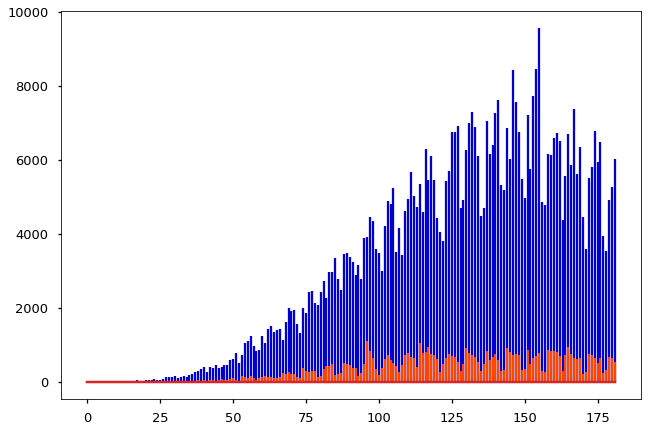

In [2]:
NumIter      = 20000
burnin       = 10000
NumEqs       =    7
NumParams    =    9

save_results_to = 'PyStan_ADVI/'


data=pd.read_csv("covidMexicoNew.csv")
yobs=data[["Suspects","Cases","Deaths"]]
#yobs=data[["Suspects","New cases (HUC)","Deaths (HUC)"]]
y_obs_temp=yobs.to_numpy()

#y_obs=y_obs_temp.astype(float)  
y_obs=y_obs_temp.astype('int32') 

mu          = 0.000046948
nu          = 0.00001589
tau         = 0.071428571  #(1/tau_Q := period of quarantined) 
alfa        = 0.196078431
  
N           = 128932753


# Initial conditions

R0 = 0
P0 = 0
  
# # HUC
Suspect = data["Suspects"]
Sick    = data["Cases"]
Deaths  = data["Deaths"] 

times  = np.linspace(0.0,float(len(Sick))-1,len(Sick))
times_pred = np.linspace(0.0,229,230)


n_days=len(Sick)

fig0= plt.figure()
#plt.stem(times, Suspect, linefmt='yellow', markerfmt=" " ,use_line_collection =True)
plt.stem(times, Sick, linefmt='mediumblue', markerfmt=" " ,use_line_collection =True)
plt.stem(times, Deaths, linefmt='orangered',markerfmt=" ",use_line_collection = True)
plt.savefig(save_results_to + 'NewCases_Deaths.eps')

In [3]:
mydata = {}
mydata['n_obs']     = len(times) 
mydata['n_params']  = NumParams
mydata['n_difeq']   = NumEqs
mydata['n_sample']  = len(times)
mydata['n_fake']    = len(times_pred)
mydata['y']         = y_obs
mydata['t0']        = -0.000001
mydata['ts']        = times
mydata['fake_ts']   = times_pred

In [4]:
########################################
# Prior


beta_s_mu = 0.
beta_s_sd = 1.
#Beta_y = ss.norm.pdf(beta_s_x, loc=beta_s_mu, scale=beta_s_sd )
beta_s_stan = 'lognormal({mu}, {sigma})'.format(mu=beta_s_mu, sigma=beta_s_sd)


beta_a_mu = 0.
beta_a_sd = 1.
#Beta_y = ss.norm.pdf(beta_s_x, loc=beta_s_mu, scale=beta_s_sd )
beta_a_stan = 'lognormal({mu}, {sigma})'.format(mu=beta_a_mu, sigma=beta_a_sd)


rho_alpha = 1.
rho_beta  = 1.
#Beta_y = ss.norm.pdf(beta_s_x, loc=beta_s_mu, scale=beta_s_sd )
rho_stan  = 'gamma({alpha}, {beta})'.format(alpha=rho_alpha, beta=rho_beta)


gamma_alpha = 1.
gamma_beta  = 1.
#Beta_y = ss.norm.pdf(beta_s_x, loc=beta_s_mu, scale=beta_s_sd )
gamma_stan = 'gamma({alpha}, {beta})'.format(alpha=gamma_alpha, beta=gamma_alpha)


sigma_alpha = 1.
sigma_beta  = 1.
#Beta_y = ss.norm.pdf(beta_s_x, loc=beta_s_mu, scale=beta_s_sd )
sigma_stan = 'gamma({alpha}, {beta})'.format(alpha=sigma_alpha, beta=sigma_beta)



qu_alpha = 0.
qu_beta  =.4
#Beta_y = ss.norm.pdf(beta_s_x, loc=beta_s_mu, scale=beta_s_sd )
qu_stan = 'uniform({alpha}, {beta})'.format(alpha=qu_alpha, beta=qu_beta)




E0_low  = 0.
E0_high = 4e4
#E0_x = np.linspace(0, y_obs.shape[0]-1, y_obs.shape[0])
#E0_y = ss.norm.pdf(s0_x, loc=s0_mu, scale=s0_sd )
E0_stan = 'uniform({alpha}, {beta})'.format(alpha=E0_low, beta=E0_high)


A0_low   = 0.
A0_high  = 8e3
#Q0_x =np.linspace(0, y_obs.shape[0]-1, y_obs.shape[0])
#Q0_y = ss.norm.pdf(i0_x, loc=i0_mu, scale=i0_sd )
A0_stan = 'uniform({alpha}, {beta})'.format(alpha=A0_low,beta= A0_high)


I0_low   = 0.
I0_high  = 1e2
#I0_x =np.linspace(0, y_obs.shape[0]-1, y_obs.shape[0])
#I0_y = ss.norm.pdf(i0_x, loc=i0_mu, scale=i0_sd )
I0_stan = 'uniform({alpha}, {beta})'.format(alpha=I0_low,beta= I0_high)


phi_1_alpha   = 7.5
phi_1_beta    = 1.0
#I0_x =np.linspace(0, y_obs.shape[0]-1, y_obs.shape[0])
#I0_y = ss.norm.pdf(i0_x, loc=i0_mu, scale=i0_sd )
phi_1_stan = 'gamma({alpha}, {beta})'.format(alpha=phi_1_alpha, beta=phi_1_beta)


phi_2_alpha   = 7.5
phi_2_beta    = 1.0
#I0_x =np.linspace(0, y_obs.shape[0]-1, y_obs.shape[0])
#I0_y = ss.norm.pdf(i0_x, loc=i0_mu, scale=i0_sd )
phi_2_stan = 'gamma({alpha}, {beta})'.format(alpha=phi_2_alpha, beta=phi_2_beta)


phi_3_alpha   = 7.5
phi_3_beta    = 1.0
#I0_x =np.linspace(0, y_obs.shape[0]-1, y_obs.shape[0])
#I0_y = ss.norm.pdf(i0_x, loc=i0_mu, scale=i0_sd )
phi_3_stan = 'gamma({alpha}, {beta})'.format(alpha=phi_3_alpha, beta=phi_3_beta)

In [5]:
# Fit
stan_code = """
functions{{
 real[] SsEAIRD(real t,       // time
               real[] y,     // system state 
               real[] params, // parameters
               real[] x_r,   // unused data
               int[] x_i){{
                  
    real dy_dt[7];
    
    real beta_s   = params[1];
    real beta_a   = params[2];
    real rho      = params[3];  
    real gama     = params[4];
    real sigma    = params[5];
    real qu       = params[6];

    
    real mu          = 0.000046948;
    real nu          = 0.00001589;
    real alfa        = 0.196078431;
    real tau         = 0.071428571;
    
    real N           = 128932753;
    
    dy_dt[1] = -( (1-qu)* beta_s*y[5] + qu* beta_s*y[5] + beta_a*y[4]  )*y[1]/N + tau*y[2];
    dy_dt[2] =  qu* beta_s*y[5]*y[1]/N  - tau*y[2];
    dy_dt[3] =  ( (1-qu)* beta_s*y[5]  + beta_a*y[4]  )*y[1]/N -alfa*y[3];
    dy_dt[4] =  rho*alfa*y[3]- gama*y[4] ; 
    dy_dt[5] =  (1-rho)*alfa*y[3] - (gama + sigma)* y[5];
    dy_dt[6] =  gama*(y[4]+y[5]);
    dy_dt[7] =  sigma*y[5] ;  
    
    return dy_dt;
  }}
}}
data{{
  int<lower = 1> n_obs; // Number of days sampled
  int<lower = 1> n_params; // Number of model parameters
  int<lower = 1> n_difeq; // Number of differential equations in the system
  int<lower = 1> n_sample; // Number of hosts sampled at each time point.
  int<lower = 1> n_fake; // This is to generate "predicted"/"unsampled" data
  

  int y[n_obs, 3]; // The binomially distributed data
//  vector[n_obs] y[3];   
  real t0; // Initial time point (zero)
  real ts[n_obs]; // Time points that were sampled
  
  real fake_ts[n_fake]; // Time points for "predicted"/"unsampled" data
  
}}
transformed data{{
  real x_r[0];
  int  x_i[0];
}}
parameters{{

  //Support of parameters
  real<lower =  0, upper = 0.45>  beta_s ;
  real<lower =  0, upper = 0.5>  beta_a ;
  real<lower =  0.65, upper = 1.0>  rho;   
  real<lower =  0, upper = 0.2>  gama;
  real<lower =  0, upper = 0.4>  sigma;
  real<lower =  0, upper = 0.4>  qu;
  real<lower =  0, upper = 4e4>  E0;
  real<lower =  0, upper = 8e3>  A0 ;
  real<lower =  0, upper = 1e2>  I0 ;
  
//  real<lower=5e-7> kappa[3];

  real<lower=5e-7> phi[3];
  
}}
transformed parameters{{

  real params[9];   
  real <lower = 0.> y_hat[n_obs, n_difeq]; // Output from the ODE solver
  real y_init[n_difeq];     // initial conditions for both fractions of S and I

  real N           = 128932753;
  //  real phi[2];
  
//  phi[1]  = 1./phi_inv[1];
//  phi[2]  = 1./ phi_inv[2];


  y_init[1] = N-( E0 +A0 + I0  );
  y_init[2] = 0.;
  y_init[3] = E0;
  y_init[4] = A0; 
  y_init[5] = I0;
  y_init[6] = 0.;
  y_init[7] = 0.;
  
  params[1] = beta_s;
  params[2] = beta_a;
  params[3] = rho;
  params[4] = gama;
  params[5] = sigma;
  params[6] = qu;
  params[7] = phi[1];
  params[8] = phi[2];
  params[9] = phi[3];
  
  y_hat = integrate_ode_rk45(SsEAIRD, y_init, t0, ts, params, x_r, x_i);
  
}}
model{{  
  // Prior distributions

    beta_s   ~ lognormal(0, 1.); 
    beta_a   ~ lognormal(0, 1.); 
    rho      ~ gamma(1, 1.); 
    gama     ~ gamma(1., 1.); 
    sigma     ~ gamma(1., 1.);
    qu       ~ uniform(0.0, 0.4 );
    E0       ~ uniform(0.0, 4e4 );
    A0       ~ uniform(0.0, 8e3 );
    I0       ~ uniform(0.0, 1e2 );
  

  phi[1]   ~ gamma(7.5, 1.);
  phi[2]   ~ gamma(7.5, 1.);
  phi[3]   ~ gamma(7.5, 1.);

  for (i in 1:(n_obs)){{
  
      y[i , 1] ~ neg_binomial_2(y_hat[i, 2], phi[1]);
      y[i , 2] ~ neg_binomial_2(y_hat[i, 5], phi[2]);
      if(i==1){{
      y[i , 3] ~ neg_binomial_2(y_hat[i, 7], phi[3]);
      }} else{{
      y[i , 3] ~ neg_binomial_2(y_hat[i, 7]-y_hat[i-1, 7], phi[3]);

      }}
      
  }}         

}}

generated quantities{{

// Generate predicted data over the whole time series:
  real epsilon = 1e-5;
  real fake[n_fake, 3];

 real <lower = 0.> y_hat_pred[n_fake, n_difeq]; // Output from the ODE solver

  y_hat_pred = integrate_ode_rk45(SsEAIRD, y_init, t0, fake_ts, params, x_r, x_i);
  for (i in 1:(n_fake)){{
  
     fake[i , 1] = neg_binomial_2_rng( y_hat_pred[i, 2] + epsilon , phi[1]);
     fake[i , 2] = neg_binomial_2_rng( y_hat_pred[i, 5] + epsilon , phi[2]);
     if(i==1){{
       fake[i , 3] = neg_binomial_2_rng( y_hat_pred[i, 7] +epsilon, phi[3]);
     }} else{{
       fake[i , 3] = neg_binomial_2_rng(y_hat_pred[i, 7] -y_hat_pred[i-1, 7] +epsilon, phi[3]);
     }}
  }}

  
}}
""".format(
        beta_s  =beta_s_stan,
        beta_a  =beta_a_stan,
        rho     =rho_stan,
        gama    =gamma_stan,
        sigma   =sigma_stan,
        qu      =qu_stan,
        E0      =E0_stan,
        A0      =A0_stan,
        I0      =I0_stan,
        phi_1   =phi_1_stan,
        phi_2   =phi_2_stan,
        phi_3   =phi_3_stan
        )

In [6]:
#inits
inits = {}
inits['beta_s']  = np.random.uniform(0.,0.2) 
inits['beta_a']  = np.random.uniform(0.,0.6)
inits['rho']     = np.random.uniform(0.65,1.0)
inits['gama']    = np.random.uniform(0.,0.2)
inits['sigma']   = np.random.uniform(0.,0.4)
inits['qu']      = np.random.uniform(0.,0.4)
inits['phi_1']  = np.random.uniform(5e-6,10.)
inits['phi_2']  = np.random.uniform(5e-6,10.)
inits['phi_3']  = np.random.uniform(5e-6,10.)
inits['E0']      = np.random.uniform(0.,4e4)
inits['A0']      = np.random.uniform(0.,8e3)
inits['I0']      = np.random.uniform(0.,1e2)

In [7]:
# compile StanModel
start_time = time.time()
sm = pystan.StanModel(model_code=stan_code)
print("--- %s seconds ---" % (time.time() - start_time))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7469c9eb69929ff3147204c55b50ffc4 NOW.


--- 48.51909136772156 seconds ---


In [8]:
# do the fitting
start_time = time.time()
fit = sm.sampling(
                  data=mydata,
                  iter=NumIter,
                  chains=6,
                  warmup=burnin,
                  seed=431,
                  init='0',
                  verbose=True,
                  algorithm='NUTS',
                  control={"adapt_delta": 0.9}
                  )
print("--- %s seconds ---" % (time.time() - start_time))

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


--- 6541.177350282669 seconds ---


In [9]:
# start_time = time.time()
# fit = sm.vb(
#                   data=mydata,
#                   iter=80000,
#                   seed=431,
# #                  init='0',
#                   verbose=True,
#                   sample_file = save_results_to + "advi_results1.csv",
# #                  algorithm='meanfield'
#                   algorithm='fullrank',
# #                  control={"adapt_delta": 0.9}
#                   )
# print("--- %s seconds ---" % (time.time() - start_time))

In [10]:
#advi_results=pd.read_csv(save_results_to + "advi_results1.csv",comment='#')

In [11]:
#advi_results

In [12]:
# fake_2=advi_results.loc[:,"y_hat_pred.1.2":"y_hat_pred.230.2"]
# fake_5=advi_results.loc[:,"y_hat_pred.1.5":"y_hat_pred.230.5"]
# fake_7=advi_results.loc[:,"y_hat_pred.1.7":"y_hat_pred.230.7"]

In [13]:
#advi_results.shape

In [14]:
# median_ppc=np.zeros((len(times_pred),3))
# CriL_ppc  =np.zeros((len(times_pred),3))
# CriU_ppc  =np.zeros((len(times_pred),3))

# median_ppc[:,0]=np.percentile(fake_2,q=50.,axis=0)
# CriL_ppc[:,0]  =np.percentile(fake_2,q=2.5,axis=0)
# CriU_ppc[:,0]  =np.percentile(fake_2,q=97.5,axis=0)

# median_ppc[:,1]=np.percentile(fake_5,q=50.,axis=0)
# CriL_ppc[:,1]  =np.percentile(fake_5,q=2.5,axis=0)
# CriU_ppc[:,1]  =np.percentile(fake_5,q=97.5,axis=0)

# median_ppc[:,2]=np.percentile(fake_5,q=50.,axis=0)
# CriL_ppc[:,2]  =np.percentile(fake_5,q=2.5,axis=0)
# CriU_ppc[:,2]  =np.percentile(fake_5,q=97.5,axis=0)

In [15]:
# plt.figure()
# ax2 = plt.subplot(111)
# ax2.stem(times, Suspect, linefmt='tomato', markerfmt=" ",basefmt=" ",label="Suspects"  )
# #    ax2.plot(ttime,Sick,linestyle='dashed', marker='o', color='mediumblue',label="Confirmed Cases")
# #ax2.plot(ttime,my_soln_I,color='mediumvioletred', lw=1.5)
# ax2.plot(times_pred,median_ppc[:,0],color='mediumblue', lw=1.5)
# ax2.fill_between(times_pred, CriL_ppc[:,0], CriU_ppc[:,0], color='blue', alpha=0.3)
# ax2.set_xlabel('Time (days)')  # Add an x-label to the axes.
# ax2.legend()  # Add a legend.
# plt.savefig(save_results_to + 'BandsPrediction_s.pdf')

In [16]:
# plt.figure()
# ax2 = plt.subplot(111)
# ax2.stem(times, Sick, linefmt='tomato', markerfmt=" ",basefmt=" ",label="Confirmed Cases"  )
# #    ax2.plot(ttime,Sick,linestyle='dashed', marker='o', color='mediumblue',label="Confirmed Cases")
# #ax2.plot(ttime,my_soln_I,color='mediumvioletred', lw=1.5)
# ax2.plot(times_pred,median_ppc[:,1],color='mediumblue', lw=1.5)
# ax2.fill_between(times_pred, CriL_ppc[:,1], CriU_ppc[:,1], color='blue', alpha=0.3)
# ax2.set_xlabel('Time (days)')  # Add an x-label to the axes.
# ax2.legend()  # Add a legend.
# plt.savefig(save_results_to + 'BandsPrediction_I.pdf')

In [17]:
# plt.figure()
# ax2 = plt.subplot(111)
# ax2.stem(times, Deaths, linefmt='tomato', markerfmt=" ",basefmt=" ",label="Deaths"  )
# #    ax2.plot(ttime,Deaths,linestyle='dashed', marker='o', color='orangered',label="Deaths")
# #ax2.plot(times,my_soln_D,color='mediumvioletred', lw=1.5)
# ax2.plot(times_pred,median_ppc[:,2],color='mediumblue', lw=1.5)
# ax2.fill_between(times_pred, CriL_ppc[:,2], CriU_ppc[:,2], color='blue', alpha=0.3)
# ax2.set_xlabel('Time (days)')  # Add an x-label to the axes.
# ax2.legend() 
# plt.savefig(save_results_to + 'BandsPrediction_P.pdf')


In [18]:
varnames = ["beta_s", "beta_a","rho","gama", "sigma","qu","E0","A0", "I0","phi"]
summary=fit.summary(pars=varnames, probs=(0.025, 0.25, 0.5, 0.75, 0.975))

In [19]:
df_summary =  pd.DataFrame(
    summary['summary'],
    columns=summary['summary_colnames'],
    index=summary['summary_rownames']
)

fit_dict= fit.extract()
fit_df = fit.to_dataframe()

In [20]:
df_summary

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
beta_s,0.222843,0.000583,0.112444,0.044544,0.129256,0.212183,0.311522,0.432766,37179.196466,0.999962
beta_a,0.329579,0.000091,0.012029,0.298919,0.323665,0.332582,0.338280,0.344919,17469.378591,1.000079
rho,0.997224,0.000001,0.000162,0.996923,0.997115,0.997218,0.997327,0.997567,23884.472232,1.000026
gama,0.190208,0.000067,0.008820,0.167264,0.185993,0.192732,0.196918,0.199714,17357.004649,1.000085
sigma,0.102517,0.000027,0.007034,0.089488,0.097648,0.102236,0.107118,0.117035,67599.529003,0.999995
qu,0.056489,0.000296,0.046746,0.019540,0.027582,0.040462,0.066428,0.192984,25010.504639,0.999954
E0,11769.739957,12.331227,2411.990240,7506.570968,10098.820414,11607.336628,13264.499084,16969.516592,38259.431824,0.999982
A0,7190.760847,3.608998,821.260419,4969.530382,6881.732765,7446.017992,7769.741827,7978.760724,51783.159072,0.999999
I0,1.228178,0.003639,0.985168,0.128882,0.536432,0.971809,1.637127,3.813730,73292.230017,0.999972
phi[1],4.048135,0.001827,0.484792,3.168774,3.711147,4.024197,4.360684,5.067418,70388.882286,0.999959


In [21]:
with open('Table_SsEAIRD_New.tex','w') as tf:
     tf.write(df_summary.to_latex())

In [22]:
data = az.from_pystan(
    posterior=fit,
    posterior_predictive="fake",
    observed_data=["y"],
)

data

Inference data with groups:
	> posterior
	> sample_stats
	> posterior_predictive
	> observed_data

INFO:numba.core.transforms:finding looplift candidates


<Figure size 748.8x514.8 with 0 Axes>

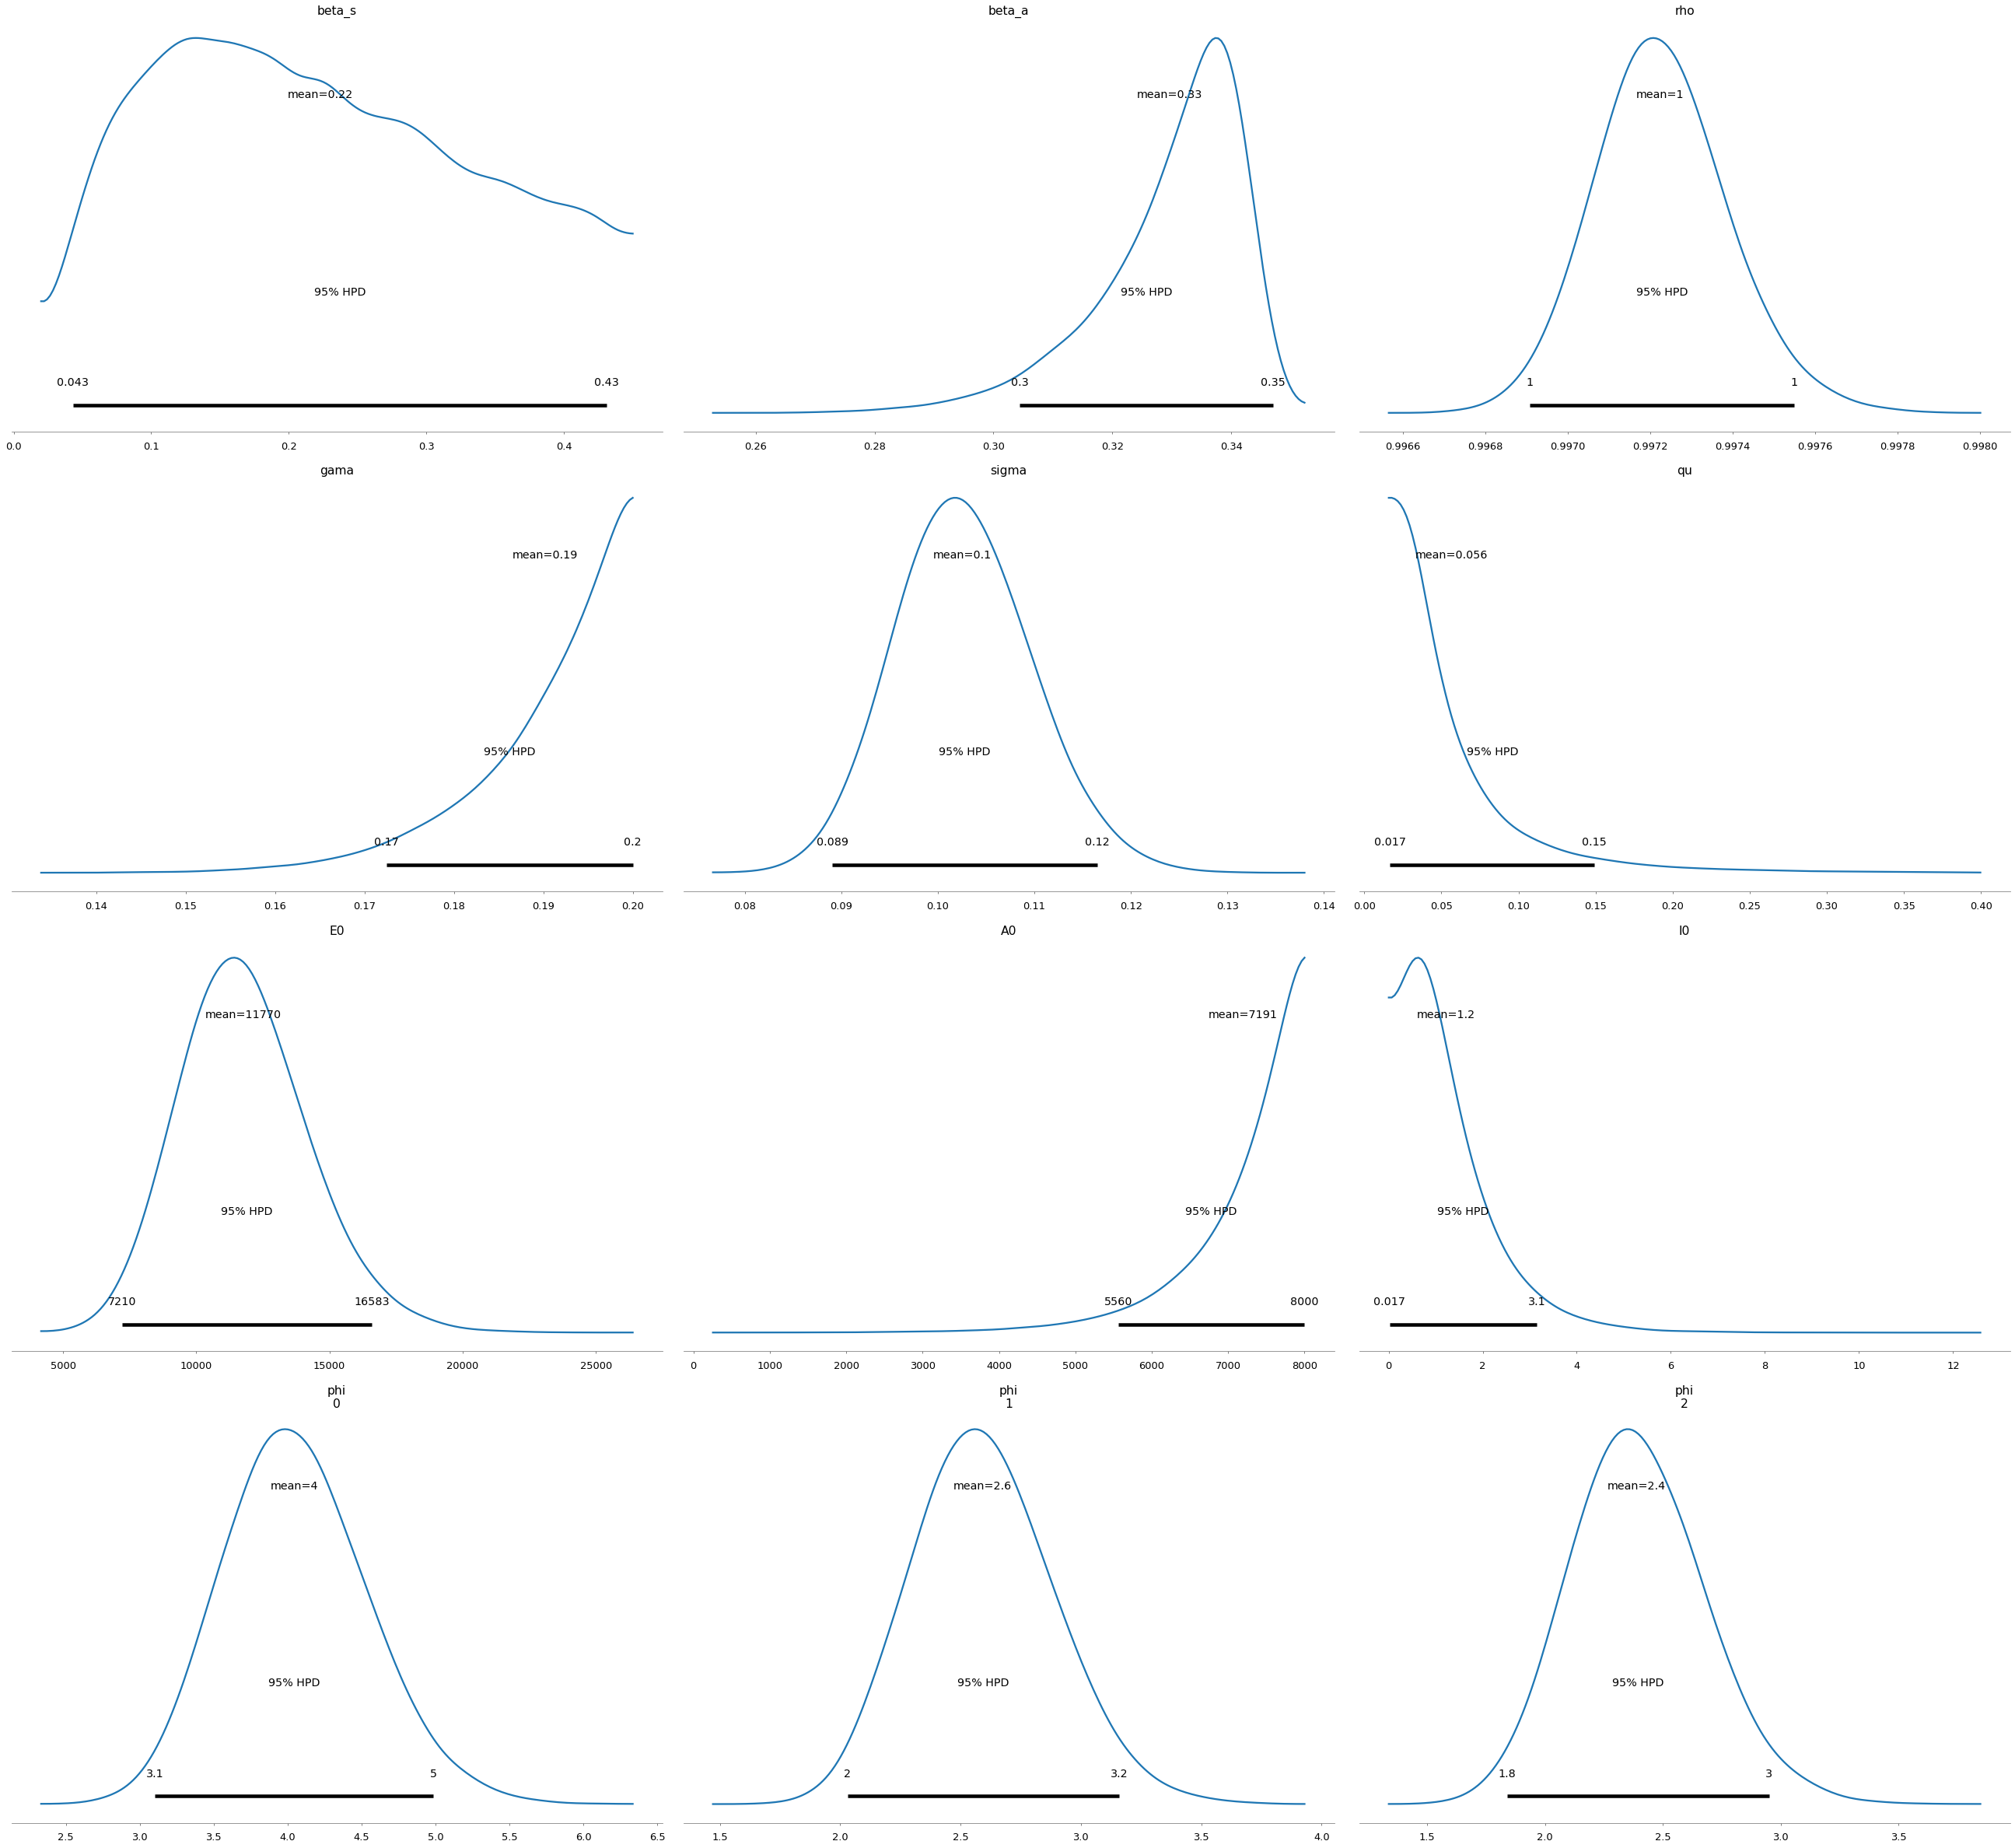

In [23]:
varnames = ["beta_s", "beta_a","rho","gama", "sigma","qu","E0","A0", "I0","phi"]
fig =plt.figure()
az.plot_posterior(data,var_names=varnames,credible_interval=0.95);
plt.savefig(save_results_to + 'credIntervalsAll_SsEAIRD.pdf')

/home/kernel/anaconda3/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/kernel/anaconda3/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/kernel/anaconda3/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/kernel/anaconda3/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/kernel/anaconda3/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument

/home/kernel/anaconda3/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/kernel/anaconda3/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/kernel/anaconda3/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/kernel/anaconda3/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/kernel/anaconda3/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument

<Figure size 748.8x514.8 with 0 Axes>

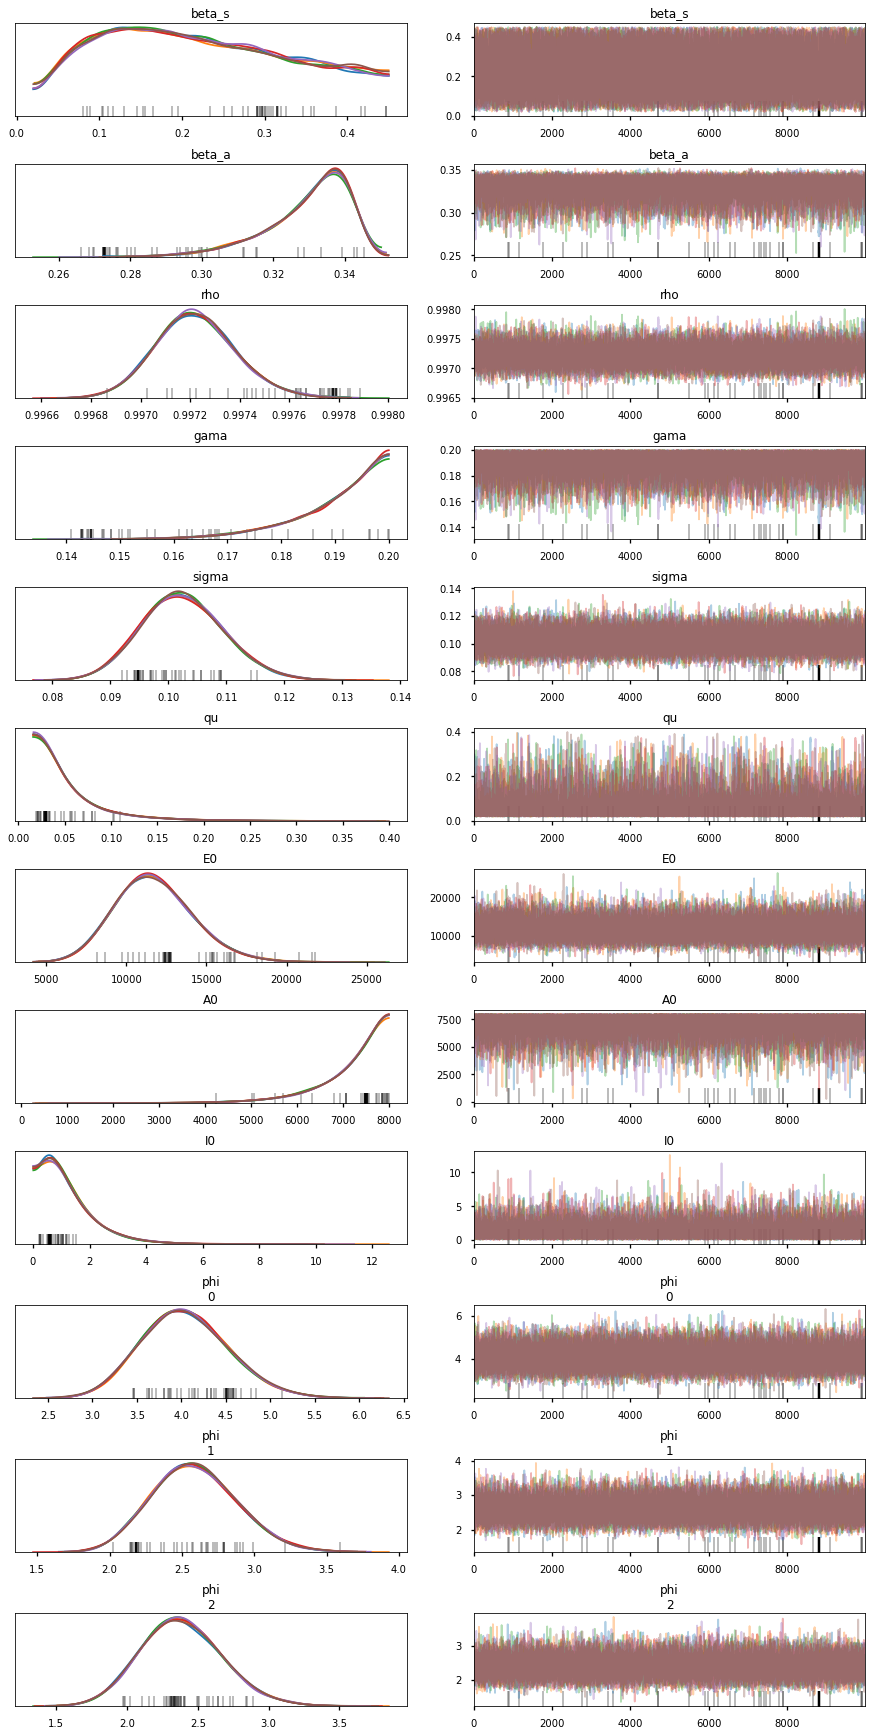

In [24]:
inference_data = az.from_pystan(fit)
plt.figure()
az.plot_trace(inference_data,var_names= varnames)
plt.savefig(save_results_to +'TraceAll_SEAIRD.pdf')

In [25]:
median_ppc = np.percentile(fit_dict['fake'],q=50.,axis=0)
CriL_ppc   = np.percentile(fit_dict['fake'],q=2.5,axis=0)
CriU_ppc   = np.percentile(fit_dict['fake'],q=97.5,axis=0)

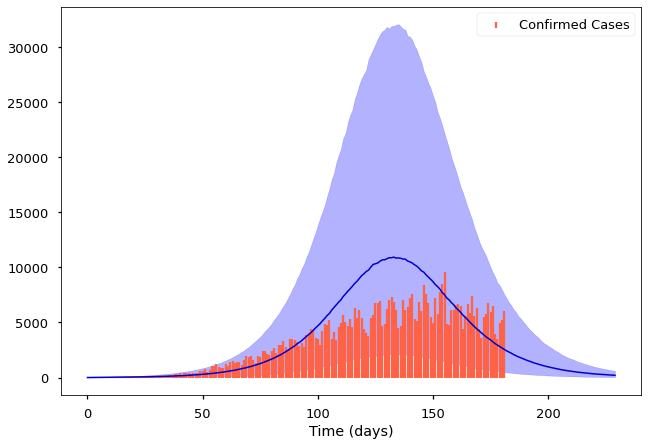

In [26]:
plt.figure()
ax2 = plt.subplot(111)
ax2.stem(times, Sick, linefmt='tomato', markerfmt=" ",basefmt=" ",label="Confirmed Cases"  )
#    ax2.plot(ttime,Sick,linestyle='dashed', marker='o', color='mediumblue',label="Confirmed Cases")
#ax2.plot(ttime,my_soln_I,color='mediumvioletred', lw=1.5)
ax2.plot(times_pred,median_ppc[:,1],color='mediumblue', lw=1.5)
ax2.fill_between(times_pred, CriL_ppc[:,1], CriU_ppc[:,1], color='blue', alpha=0.3)
ax2.set_xlabel('Time (days)')  # Add an x-label to the axes.
ax2.legend()  # Add a legend.
plt.savefig(save_results_to + 'BandsPrediction_I.pdf')

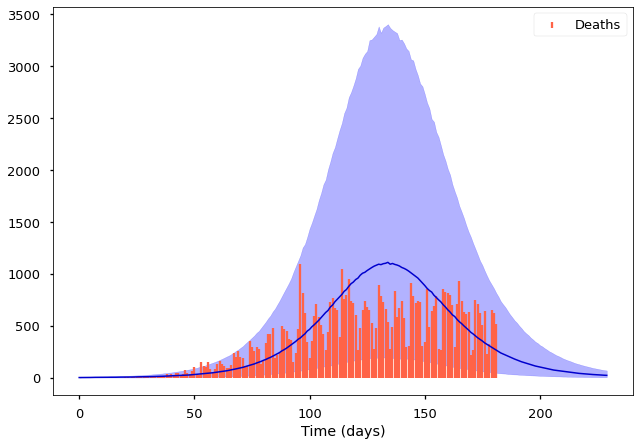

In [27]:
plt.figure()
ax2 = plt.subplot(111)
ax2.stem(times, Deaths, linefmt='tomato', markerfmt=" ",basefmt=" ",label="Deaths"  )
#    ax2.plot(ttime,Deaths,linestyle='dashed', marker='o', color='orangered',label="Deaths")
#ax2.plot(times,my_soln_D,color='mediumvioletred', lw=1.5)
ax2.plot(times_pred,median_ppc[:,2],color='mediumblue', lw=1.5)
ax2.fill_between(times_pred, CriL_ppc[:,2], CriU_ppc[:,2], color='blue', alpha=0.3)
ax2.set_xlabel('Time (days)')  # Add an x-label to the axes.
ax2.legend() 
plt.savefig(save_results_to + 'BandsPrediction_P.pdf')


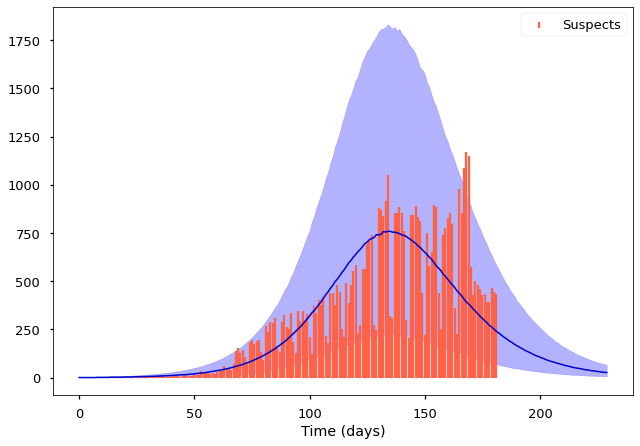

In [28]:
plt.figure()
ax2 = plt.subplot(111)
ax2.stem(times, Suspect, linefmt='tomato', markerfmt=" ",basefmt=" ",label="Suspects"  )
#    ax2.plot(ttime,Sick,linestyle='dashed', marker='o', color='mediumblue',label="Confirmed Cases")
#ax2.plot(ttime,my_soln_I,color='mediumvioletred', lw=1.5)
ax2.plot(times_pred,median_ppc[:,0],color='mediumblue', lw=1.5)
ax2.fill_between(times_pred, CriL_ppc[:,0], CriU_ppc[:,0], color='blue', alpha=0.3)
ax2.set_xlabel('Time (days)')  # Add an x-label to the axes.
ax2.legend()  # Add a legend.
plt.savefig(save_results_to + 'BandsPrediction_s.pdf')

In [29]:
#varnames = ["beta_s", "beta_r",  "delta", "Karga","s0","i0"]
pystan_trace = [fit_dict['beta_s'], fit_dict['beta_a'], fit_dict['rho'],fit_dict['gama'],
                fit_dict['sigma'],fit_dict['qu'],fit_dict['E0'],fit_dict['A0'],fit_dict['I0']]

In [30]:
trace=np.array(pystan_trace)
trace_df = pd.DataFrame(pystan_trace) 
map=np.median(trace,axis=1)
range = np.array([(0.5*x,1.5*x) for x in map])

<Figure size 748.8x514.8 with 0 Axes>

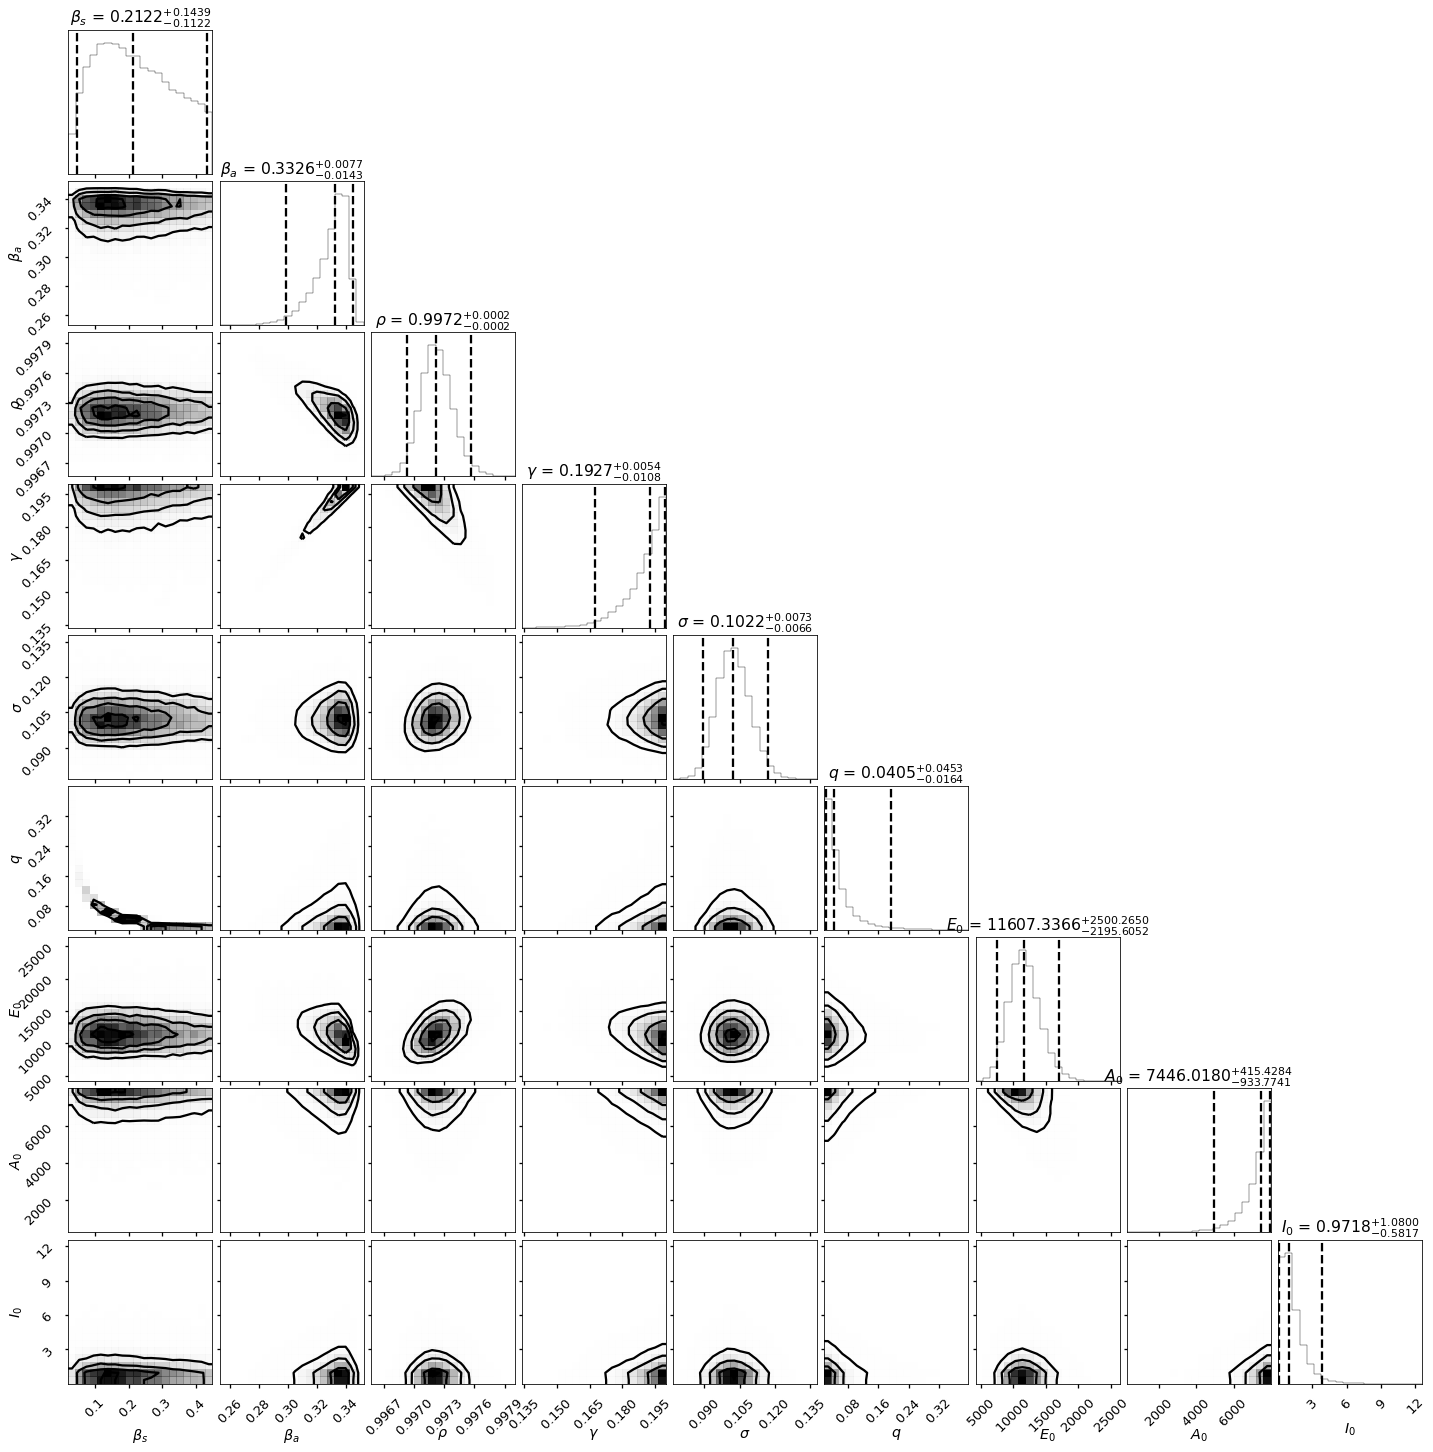

In [31]:
varnames=[r"$\beta_{s}$", r"$\beta_{a}$" , r"$\rho$" , r"$\gamma$",r"$\sigma$",r"$q$",
          r"$E_{0}$",r"$A_{0}$",r"$I_{0}$"]
plt.figure()
corner.corner(trace_df.T,show_titles=True,labels=varnames,
                    plot_datapoints=False,quantiles=[0.025, 0.5, 0.975],
             use_math_text=True,title_fmt='.4f')
plt.savefig(save_results_to +'corner_SEAIRD_New.pdf')

<Figure size 748.8x514.8 with 0 Axes>

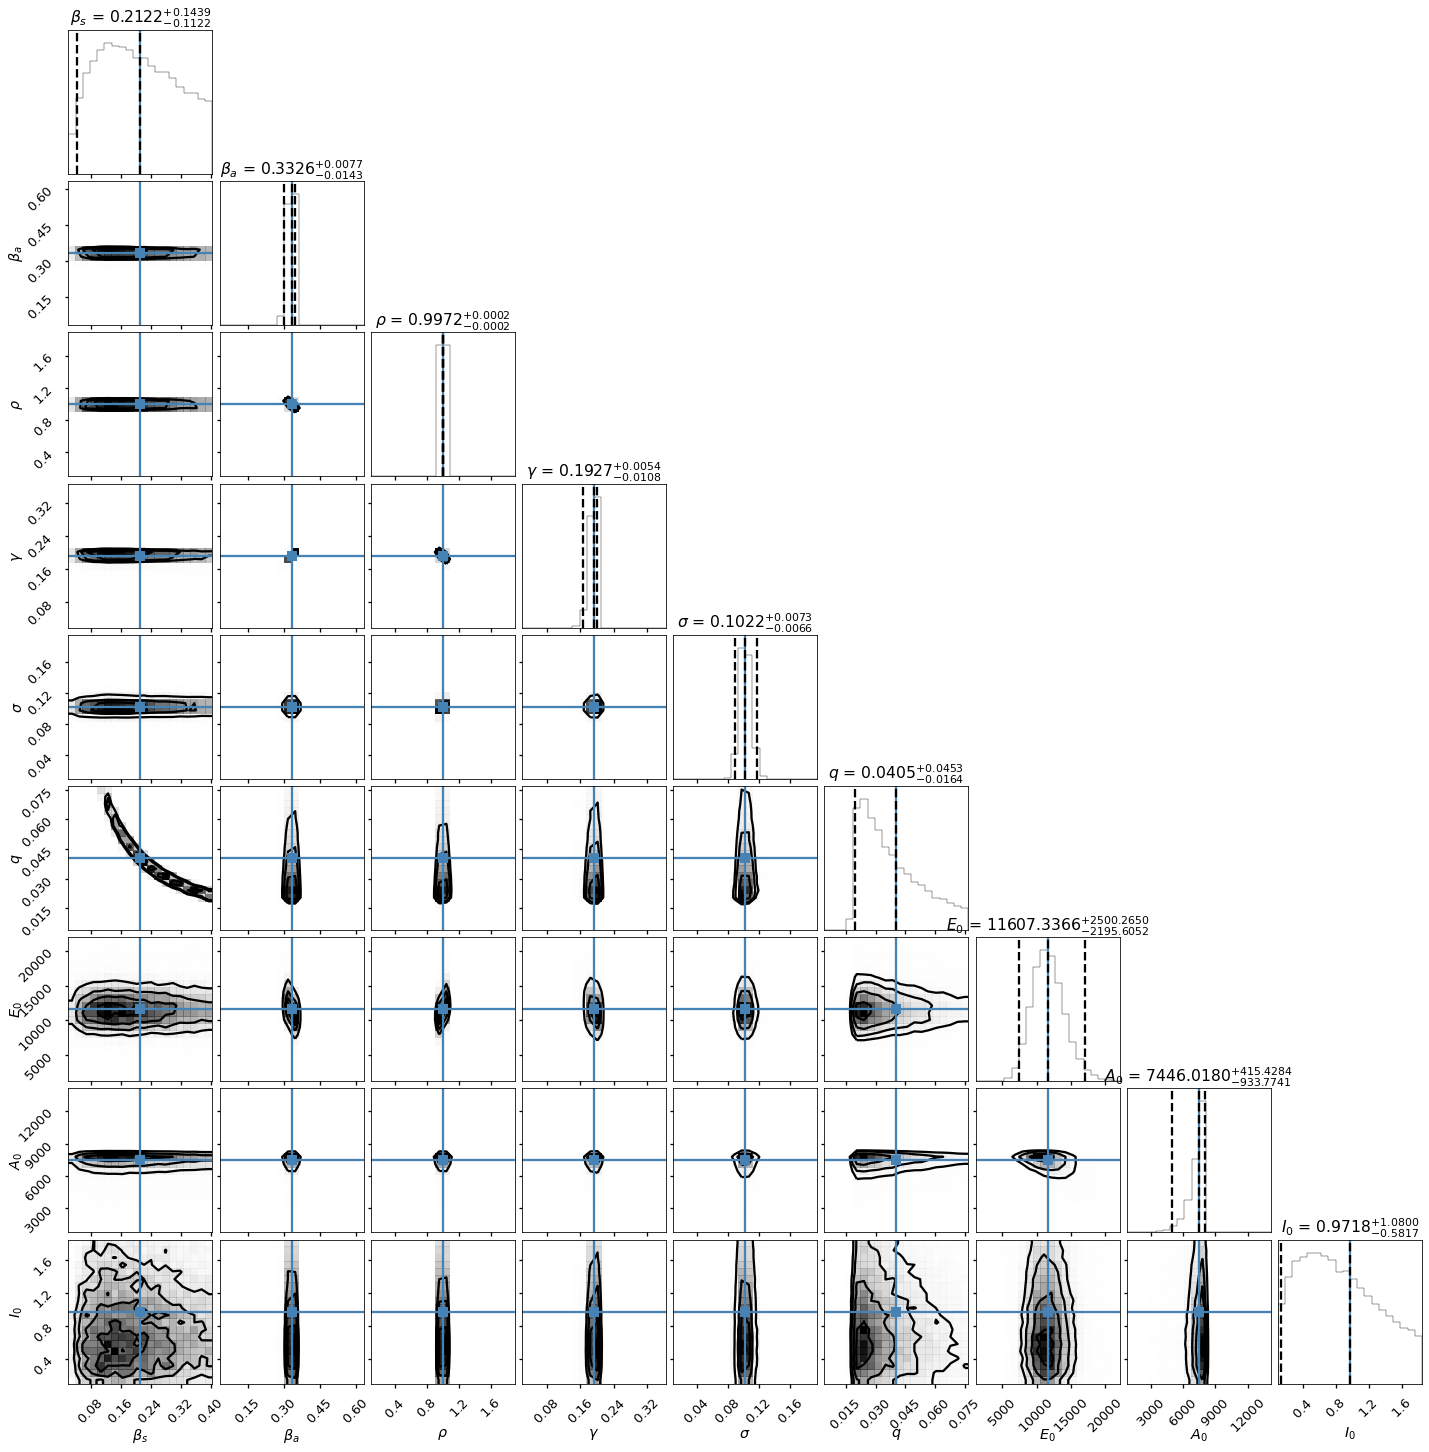

In [32]:
varnames=[r"$\beta_{s}$", r"$\beta_{a}$" , r"$\rho$" , r"$\gamma$",r"$\sigma$",r"$q$",
          r"$E_{0}$",r"$A_{0}$",r"$I_{0}$"]
range = np.array([(0.1*x,1.9*x) for x in map])
plt.figure()
corner.corner(trace_df.T,show_titles=True,labels=varnames,truths=map,range=range,
                    plot_datapoints=False,quantiles=[0.025, 0.5, 0.975],
              use_math_text=True,title_fmt='.4f')
plt.savefig(save_results_to +'corner_SEAIRD1_New.pdf')